Link prediction demo for cora dataset (homegeneous network) where all nodes are papers and edges between nodes are citation links, e.g., paper A cites paper B. 

Each paper has a **subject** attribute with one of 7 values denoting the subject area of the paper.

This demo notebook demonstrates how to predict citation links between papers using the random walk-based representation learning method Node2Vec.

In [34]:
import os
import numpy as np
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# stellar ml library imports
from stellar.data.epgm import EPGM
from stellar.data.edge_splitter import EdgeSplitter
# Node2Vec representation learning
from utils.node2vec_feature_learning import Node2VecFeatureLearning

In [10]:
# Default parameters for Node2Vec
parameters = {
    "p": 1.,  # Parameter p
    "q": 1.,  # Parameter q
    "dimensions": 128,  # dimensionality of node2vec embeddings
    "num_walks": 10,  # Number of walks from each node
    "walk_length": 80,  # Walk length
    "window_size": 10,  # Context size for word2vec
    "iter": 1,  # number of SGD iterations (epochs)
    "workers": multiprocessing.cpu_count(),  # number of workers for word2vec
    "weighted": False,  # is graph weighted?
    "directed": False,  # are edges directed?
}

In [24]:
def read_graph(graph_file, dataset_name):
    """
    Reads the input network in networkx.

    Args:
        graph_file: The directory where graph in EPGM format is stored.
        dataset_name: The name of the graph selected out of all the graph heads in EPGM file.

    Returns:
        The graph in networkx format
    """
    try:  # assume args.input points to an EPGM graph
        G_epgm = EPGM(graph_file)
        graphs = G_epgm.G["graphs"]
        if (
            dataset_name is None
        ):  # if dataset_name is not given, use the name of the 1st graph head
            dataset_name = graphs[0]["meta"]["label"]
            print(
                "WARNING: dataset name not specified, using dataset '{}' in the 1st graph head".format(
                    dataset_name
                )
            )
        graph_id = None
        for g in graphs:
            if g["meta"]["label"] == dataset_name:
                graph_id = g["id"]

        g = G_epgm.to_nx(graph_id, parameters["directed"])
        if parameters["weighted"]:
            raise NotImplementedError
        else:
            # This is the correct way to set the edge weight in a MultiGraph.
            edge_weights = {e: 1 for e in g.edges(keys=True)}
            nx.set_edge_attributes(g, "weight", edge_weights)
    except:  # otherwise, assume arg.input points to an edgelist file
        if parameters["weighted"]:
            g = nx.read_edgelist(
                graph_file,
                nodetype=int,
                data=(("weight", float),),
                create_using=nx.DiGraph(),
            )
        else:
            g = nx.read_edgelist(graph_file, nodetype=int, create_using=nx.DiGraph())
            for edge in g.edges():
                g[edge[0]][edge[1]]["weight"] = 1  # {'weight': 1}

        if not parameters["directed"]:
            g = g.to_undirected()

    print(
        "Graph statistics: {} nodes, {} edges".format(
            g.number_of_nodes(), g.number_of_edges()
        )
    )
    return g


def print_distance_probabilities(node_distances):
    counts = Counter(node_distances)
    d_total = sum(counts.values())
    counts_normalized = {k: v / d_total for k, v in counts.items()}
    counts_normalized = sorted(counts_normalized.items(), key=lambda x: x[0])
    counts = [v for k, v in counts_normalized]
    print(
        "Normalized distances between source and target nodes in negative samples: {}".format(
            counts
        )
    )


def link_prediction_clf(feature_learner, edge_data, binary_operators=None):
    """
    Performs link prediction given that node features have already been computed. It uses the node features to
    derive edge features using the operators given. Then it trains a Logistic Regression classifier to predict
    links between nodes.

    Args:
        feature_learner: Representation learning object.
        edge_data: (2-tuple) Positive and negative edge data for training the classifier
        binary_operators: Binary operators applied on node features to produce the corresponding edge feature.

    Returns:
        Returns the ROCAUC score achieved by the classifier for each of the specified binary operators.
    """
    scores = []  # the auc values for each binary operator (based on test set performance)
    clf_best = None
    score_best = 0
    op_best = ""

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    # for each type of binary operator
    for binary_operator in binary_operators:
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        # Split the data and keep X_test, y_test for scoring the model; setting the random_state to
        # the same constant for every iteration gives the same split of data so the comparison is fair.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, test_size=0.25
        )
        # LogisticRegressionCV automatically tunes the parameter C using cross validation and the ROC AUC metric
        clf = Pipeline(
            steps=[
                ("sc", StandardScaler()),
                (
                    "clf",
                    LogisticRegressionCV(
                        Cs=10, cv=10, scoring="roc_auc", verbose=False
                    ),
                ),
            ]
        )
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)  # predict on the test set
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y_test, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y_test, y_pred[:, 1])

        if score_auc >= score_best:
            score_best = score_auc
            clf_best = clf
            op_best = binary_operator

        print(
            "Operator: {} Score (on test set of edge_data): {}".format(
                binary_operator, score_auc
            )
        )
        scores.append({"op": binary_operator, "score": score_auc})

    return scores, clf_best, op_best


def predict_links(feature_learner, edge_data, clf, binary_operators=None):
    """
    Given a node feature learner and a trained classifier, it computes edge features, uses the classifier to predict
    the given edge data and calculate prediction accuracy.
    :param feature_learner:
    :param edge_data:
    :param clf:
    :param binary_operators:
    :return:
    """
    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    scores = []  # the auc values for each binary operator (based on test set performance)

    # for each type of binary operator
    for binary_operator in binary_operators:
        # Derive edge features from node features using the given binary operator
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        y_pred = clf.predict_proba(X)  # predict
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y, y_pred[:, 1])

        print("Prediction score:", score_auc)
        scores.append({"op": binary_operator, "score": score_auc})

    return scores

def train_homogeneous_graph(
    g_train,
    g_test,
    output_node_features,  # filename for writing node embeddings
    edge_data_ids_train,
    edge_data_labels_train,  # train edge data
    edge_data_ids_test,
    edge_data_labels_test,  # test edge data
):
    # Using g_train and edge_data_train train a classifier for edge prediction
    feature_learner_train = Node2VecFeatureLearning(
        g_train, embeddings_filename=os.path.expanduser(output_node_features)
    )
    feature_learner_train.fit(
        p=parameters["p"],
        q=parameters["q"],
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )
    # Train the classifier
    binary_operators = ["h", "avg", "l1", "l2"]
    scores_train, clf_edge, binary_operator = link_prediction_clf(
        feature_learner=feature_learner_train,
        edge_data=(edge_data_ids_train, edge_data_labels_train),
        binary_operators=binary_operators,
    )

    # Do representation learning on g_test and use the previously trained classifier on g_train to predict
    # edge_data_test
    feature_learner_test = Node2VecFeatureLearning(
        g_test, embeddings_filename=os.path.expanduser(output_node_features)
    )
    feature_learner_test.fit(
        p=parameters["p"],
        q=parameters["q"],
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )

    scores = predict_links(
        feature_learner=feature_learner_test,
        edge_data=(edge_data_ids_test, edge_data_labels_test),
        clf=clf_edge,
        binary_operators=[binary_operator],
    )

    print("\n  **** Scores on test set ****\n")
    for score in scores:
        print("     Operator: {}  Score: {:.2f}".format(score["op"], score["score"]))
    print("\n  ****************************")
    
    return feature_learner_train, feature_learner_test

#### Load the dataset

In [13]:
cora_epgm_location = os.path.expanduser("~/Projects/data/cora/cora.epgm/")
dataset_name = 'cora'
g_nx = read_graph(graph_file=cora_epgm_location, dataset_name=dataset_name)

...reading /Users/eli024/Projects/data/cora/cora.epgm/graphs.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/vertices.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/edges.json using utf-8 encoding...
Converting the EPGM graph 9ccd0dd106204767a723747a8b8d5b8a to NetworkX graph...
Graph statistics: 2708 nodes, 5278 edges


#### Construct train and test splits of the input data

In [18]:
# Test graph and edge test data
edge_splitter_test = EdgeSplitter(g_nx)
g_test, edge_data_ids_test, edge_data_labels_test = edge_splitter_test.train_test_split( 
    p=0.1, method='global'
)

# Train graph and edge train data
edge_splitter_train = EdgeSplitter(g_test, g_nx)
g_train, edge_data_ids_train, edge_data_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method='global'
)

** Sampled 264 positive and 264 negative edges. **
** Sampled 238 positive and 238 negative edges. **


In [19]:
# Train and Test graphs should be of type nx.Graph
g_test = nx.Graph(g_test)
g_train = nx.Graph(g_train)

#### Train the link prediction model and evaluate on test data

In [25]:
train_fl, test_fl = train_homogeneous_graph(
    g_train=g_train,
    g_test=g_test,
    output_node_features='embeddings.emb',
    edge_data_ids_train=edge_data_ids_train,
    edge_data_labels_train=edge_data_labels_train,
    edge_data_ids_test=edge_data_ids_test,
    edge_data_labels_test=edge_data_labels_test,
)

(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 9 seconds.
Total time for fit() 18.865509271621704 seconds
Operator: h Score (on test set of edge_data): 0.9186440677966101
Operator: avg Score (on test set of edge_data): 0.65625
Operator: l1 Score (on test set of edge_data): 0.9643866591294517
Operator: l2 Score (on test set of edge_data): 0.9783475783475784
(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 9 seconds.
Total time for fit() 18.811742067337036 seconds
Prediction score: 0.940685261708

  **** Scores on test set ****

     Operator: l2  Score: 0.94

  ****************************


In [26]:
edge_data = (edge_data_ids_test, edge_data_labels_test)
X, y = test_fl.transform(edge_data, 'h')

(528, 128)
(528,)


#### Visualise representations of edge data

Learned edge embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions. Green points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

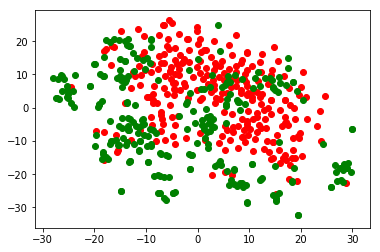

In [44]:
tsne = TSNE(n_components=2, init='random', random_state=0)
X_transformed = tsne.fit_transform(X)
red = y == 0
green = y == 1
plt.scatter(X_transformed[red, 0], X_transformed[red, 1], c="r")
plt.scatter(X_transformed[green, 0], X_transformed[green, 1], c="g")